<a href="https://colab.research.google.com/github/jh941213/NLP/blob/main/seq2seq_project(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq


!apt-get install fonts-nanum* -qq

In [2]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


Text(0.5, 1.0, '한글 제목')

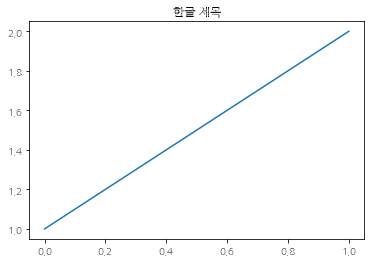

In [3]:
plt.plot([1,2])
plt.title("한글 제목")

In [4]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download data


In [6]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
To: /content/1_구어체(1).xlsx
100% 15.8M/15.8M [00:00<00:00, 164MB/s]


In [7]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space.
embedding_dim = 64
num_samples = 200000  # Number of samples to train on.

In [86]:
import pandas as pd
df = pd.read_excel('/content/1_구어체(1).xlsx')
df



/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,SID,원문,번역문
0,200001.0,0 설정을 입력하고 안정될 때까지 5분 동안 기다린 후 OK 버튼을 길게 누르십시오.,"Enter into 0 setting, and wait for 5 minutes t..."
1,200002.0,0은 그들에게 아무것도 아니었지만 무는 숫자일 수가 없습니다.,The zero was nothing for them but nothing coul...
2,200003.0,"1,015버전에서 핫키 버그가 있습니다.","There is a Hotkey bug in the 1,015 version."
3,200004.0,"1,390점에서 1,440점을 득점한 사람은 재판을 위해 걸러집니다.","Individuals who got a score between 1,390 and ..."
4,200005.0,"1,400년보다 오래 전의 유적지에 있는 최초의 성당에서 숭배자들은 그것을 인지했을...","Indeed, worshippers at the very first cathedra..."
...,...,...,...
199995,399996.0,당신은 곧 당신의 조카를 볼 수 있어요.,You can see your nephew soon.
199996,399997.0,나는 당신이 내게 공유한 음악을 들었어요.,I've listened to the music that you shared wit...
199997,399998.0,그 서류는 당신이 공유해 준 것과 달라요.,The document is different from what you shared.
199998,399999.0,당신이 잡지에 광고 낸 것을 봤어요.,I saw your advertisement in the magazine.


In [ ]:
total_df = pd.concat(df, df2,axis=1)

In [87]:
df2 = pd.read_excel('/content/df2.xlsx')
df2

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,SID,원문,번역문
0,200001.0,0 설정을 입력하고 안정될 때까지 5분 동안 기다린 후 OK 버튼을 길게 누르십시오.,"Enter into 0 setting, and wait for 5 minutes t..."
1,200002.0,0은 그들에게 아무것도 아니었지만 무는 숫자일 수가 없습니다.,The zero was nothing for them but nothing coul...
2,200003.0,"1,015버전에서 핫키 버그가 있습니다.","There is a Hotkey bug in the 1,015 version."
3,200004.0,"1,390점에서 1,440점을 득점한 사람은 재판을 위해 걸러집니다.","Individuals who got a score between 1,390 and ..."
4,200005.0,"1,400년보다 오래 전의 유적지에 있는 최초의 성당에서 숭배자들은 그것을 인지했을...","Indeed, worshippers at the very first cathedra..."
...,...,...,...
199995,399996.0,당신은 곧 당신의 조카를 볼 수 있어요.,You can see your nephew soon.
199996,399997.0,나는 당신이 내게 공유한 음악을 들었어요.,I've listened to the music that you shared wit...
199997,399998.0,그 서류는 당신이 공유해 준 것과 달라요.,The document is different from what you shared.
199998,399999.0,당신이 잡지에 광고 낸 것을 봤어요.,I saw your advertisement in the magazine.


In [93]:
total_df = pd.concat([df, df2],axis=0)

In [94]:
total_df

,SID,원문,번역문
0,1.0,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2.0,씨티은행에서 일하세요?,Do you work at a City bank?
2,3.0,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4.0,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5.0,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
199995,399996.0,당신은 곧 당신의 조카를 볼 수 있어요.,You can see your nephew soon.
199996,399997.0,나는 당신이 내게 공유한 음악을 들었어요.,I've listened to the music that you shared wit...
199997,399998.0,그 서류는 당신이 공유해 준 것과 달라요.,The document is different from what you shared.
199998,399999.0,당신이 잡지에 광고 낸 것을 봤어요.,I saw your advertisement in the magazine.


In [95]:
import re 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from konlpy.tag import Okt 

okt = Okt()
tokenizer = Tokenizer()

In [10]:
df

,SID,원문,번역문
0,1,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2,씨티은행에서 일하세요?,Do you work at a City bank?
2,3,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
199995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
199996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
199997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
199998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


In [96]:
kor = total_df['원문']
eng = total_df['번역문']

In [115]:
len(kor), len(eng)

(400000, 400000)

In [116]:
#   데이터 전처리를 위한 함수
import re
def preprocessing(sent):
    sent = re.sub(r'[^가-힣ㄱ-ㅎa-zA-Z0-9~₩!@#$%^&*()_-{}"/+.?]+',r' ',sent)
    sent = re.sub(r'\s+',' ',sent)
    return sent


In [118]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], [] 
  
    for tar_line, src_line in zip(tqdm(eng),kor):
        src_line = [w for w in preprocessing(src_line).split()]


    # target 데이터 전처
        tar_line = preprocessing(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋 
        tar_line_out = [w for w in (tar_line + " <eos>").split()]

        encoder_input.append(src_line)
        decoder_input.append(tar_line_in)
        decoder_target.append(tar_line_out)
    

    return encoder_input, decoder_input, decoder_target

In [119]:
sents_kor_in, sents_en_in, sents_en_out  = load_preprocessed_data()

100%|██████████| 400000/400000 [00:11<00:00, 35900.36it/s]


In [120]:
print('인코더의 입력 :',sents_kor_in[:5])
print('디코더의 입력 :',sents_en_in[:5])
print('디코더의 레이블 :',sents_en_out[:5])

인코더의 입력 : [['Bible', 'Coloring', '은', '성경의', '아름다운', '이야기를', '체험', '할', '수', '있는', '컬러링', '앱입니다.'], ['씨티은행에서', '일하세요?'], ['푸리토의', '베스트셀러는', '해외에서', '입소문만으로', '4차', '완판을', '기록하였다.'], ['11장에서는', '예수님이', '이번엔', '나사로를', '무덤에서', '불러내어', '죽은', '자', '가운데서', '살리셨습니다.'], ['6.5', '7', '8', '사이즈가', '몇', '개나', '더', '재입고', '될지', '제게', '알려주시면', '감사하겠습니다.']]
디코더의 입력 : [['<sos>', 'Bible', 'Coloring', 'is', 'a', 'coloring', 'application', 'that', 'allows', 'you', 'to', 'experience', 'beautiful', 'stories', 'in', 'the', 'Bible.'], ['<sos>', 'Do', 'you', 'work', 'at', 'a', 'City', 'bank?'], ['<sos>', 'PURITO', 's', 'bestseller', 'which', 'recorded', '4th', 'rough', 'cuts', 'by', 'words', 'of', 'mouth', 'from', 'abroad.'], ['<sos>', 'In', 'Chapter', '11', 'Jesus', 'called', 'Lazarus', 'from', 'the', 'tomb', 'and', 'raised', 'him', 'from', 'the', 'dead.'], ['<sos>', 'I', 'would', 'feel', 'grateful', 'to', 'know', 'how', 'many', 'stocks', 'will', 'be', 'secured', 'of', 'size', '6.5', '7', 'and', '8.']]
디코더의

In [121]:
#한국어
tokenizer_kor = Tokenizer(filters="", lower=False)#text 단위로 토큰화
tokenizer_kor.fit_on_texts(sents_kor_in)

#인코더 데이터
encoder_input = tokenizer_kor.texts_to_sequences(sents_kor_in)#숫자로 변환

In [122]:
#영어
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
tokenizer_en.fit_on_texts(sents_en_out)

print(tokenizer_en.word_index)

{'the': 1, '<sos>': 2, '<eos>': 3, 'I': 4, 'to': 5, 'a': 6, 'you': 7, 'is': 8, 'of': 9, 'and': 10, 'in': 11, 'for': 12, 'that': 13, 'it': 14, 'with': 15, 'have': 16, 'my': 17, 'are': 18, 's': 19, 'The': 20, 'be': 21, 't': 22, 'on': 23, 'will': 24, 'can': 25, 'your': 26, 'this': 27, 'was': 28, 'It': 29, 'not': 30, 'as': 31, 'me': 32, 'we': 33, 'at': 34, 'We': 35, 'like': 36, 'from': 37, 'so': 38, 'm': 39, 'by': 40, 'do': 41, 'about': 42, 'an': 43, 'want': 44, 'but': 45, 'if': 46, 'when': 47, 'You': 48, 'because': 49, 'am': 50, 'Please': 51, 'there': 52, 'has': 53, 'go': 54, 'This': 55, 'get': 56, 'time': 57, 'know': 58, 'don': 59, 'think': 60, 'If': 61, 'would': 62, 'or': 63, 'our': 64, 'all': 65, 'after': 66, 'who': 67, 'good': 68, 'one': 69, 'more': 70, 'make': 71, 'There': 72, 'What': 73, 'My': 74, 'people': 75, 'been': 76, 'going': 77, 'you.': 78, 'up': 79, 'should': 80, 'He': 81, 'out': 82, 'what': 83, 'they': 84, 'll': 85, 'send': 86, 'need': 87, 'he': 88, 'take': 89, 'just': 90, 

In [123]:
# 영어
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
tokenizer_en.fit_on_texts(sents_en_out)
# 디코더 데이터
decoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_en.texts_to_sequences(sents_en_out)

In [124]:
decoder_input[-5:] , decoder_target[-5:]

([[2, 48, 25, 103, 26, 5561, 588],
  [2, 4, 130, 3193, 5, 1, 478, 13, 7, 2362, 15, 97],
  [2, 20, 486, 8, 209, 37, 83, 7, 13528],
  [2, 4, 391, 26, 2220, 11, 1, 10155],
  [2, 4, 39, 140, 788, 7, 177, 65, 161, 158]],
 [[48, 25, 103, 26, 5561, 588, 3],
  [4, 130, 3193, 5, 1, 478, 13, 7, 2362, 15, 97, 3],
  [20, 486, 8, 209, 37, 83, 7, 13528, 3],
  [4, 391, 26, 2220, 11, 1, 10155, 3],
  [4, 39, 140, 788, 7, 177, 65, 161, 158, 3]])

In [125]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post') #각 인코더 , 디코더 크기 만큼 패딩을 씌어준다.
decoder_target = pad_sequences(decoder_target, padding='post')

In [126]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (400000, 30)
디코더의 입력의 크기(shape) : (400000, 54)
디코더의 레이블의 크기(shape) : (400000, 54)


In [127]:
print(tokenizer_en.word_index)
print(tokenizer_kor.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [128]:
# 0때문에 임베딩 과정에서 + 1 을 더해준다
src_vocab_size = len(tokenizer_kor.word_index) + 1
tar_vocab_size = len(tokenizer_en.word_index) + 1

In [129]:
src_vocab_size, tar_vocab_size

(336563, 96378)

In [130]:
src_to_index = tokenizer_kor.word_index  # word : idx
index_to_src = tokenizer_kor.index_word  # idx : word
tar_to_index = tokenizer_en.word_index # word : idx
index_to_tar = tokenizer_en.index_word # idx : word

In [131]:
index_to_src[100], index_to_tar[100]

('알고', 'it.')

In [132]:
print(src_to_index)
print(index_to_src)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [133]:
# 섞어준다
arr = np.arange(5) + 100
print(arr)
arr[[1, 3, 0, 2, 4]]

[100 101 102 103 104]


array([101, 103, 100, 102, 104])

In [134]:
# 셔플용 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)



랜덤 시퀀스 : [ 92338 379486  97364 ... 110974 222617  82391]


In [135]:
encoder_input

array([[127892, 127893,   3555, ...,      0,      0,      0],
       [ 44357,  52224,      0, ...,      0,      0,      0],
       [127894,  84013,   4828, ...,      0,      0,      0],
       ...,
       [     6,   2082,     11, ...,      0,      0,      0],
       [    11,  17730,   2074, ...,      0,      0,      0],
       [    11,    126,  99384, ...,      0,      0,      0]], dtype=int32)

In [136]:
# 배열
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [137]:
decoder_input[indices[0]], decoder_target[indices[0]]

(array([   2,  382,  298,   66, 4243, 1021,  525,   34,    1,  970,    9,
        7462,   24,   21,  439,    6,  228,    9,    6, 1141, 2576, 1631,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       dtype=int32),
 array([ 382,  298,   66, 4243, 1021,  525,   34,    1,  970,    9, 7462,
          24,   21,  439,    6,  228,    9,    6, 1141, 2576, 1631,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       dtype=int32))

In [138]:
n_of_val = int(num_samples*0.1) # 900

encoder_input_train = encoder_input[:-n_of_val] 
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [139]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (380000, 30)
훈련 target 데이터의 크기 : (380000, 54)
훈련 target 레이블의 크기 : (380000, 54)
테스트 source 데이터의 크기 : (20000, 30)
테스트 target 데이터의 크기 : (20000, 54)
테스트 target 레이블의 크기 : (20000, 54)


# modeling

In [140]:
import tensorflow as tf
import os

In [40]:
# 직접 만들어보세요!
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [141]:
# 핸들링 가능
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space.
embedding_dim = 64

In [142]:
src_vocab_size

336563

첫번째 인자 = 단어 집합의 크기. 즉, 총 단어의 개수

두번째 인자 = 임베딩 벡터의 출력 차원. 결과로서 나오는 임베딩 벡터의 크기

input_length = 입력 시퀀스의 길이

In [147]:
from tensorflow.keras.layers import Input

# 인코더

# input shape
# 임베딩 층 # 히든디멘저
enc_emb_layer = Embedding(src_vocab_size, embedding_dim)

# 상태값 리턴을 위해 return_state는 True
encoder_lstm = LSTM(hidden_units ,return_sequences=True, return_state = True)
encoder_lstm2 = LSTM(hidden_units ,return_sequences=True, return_state = True)
# 은닉 상태와 셀 상태를 리턴


encoder_inputs = Input(shape=(None, ))
enc_emb = enc_emb_layer(encoder_inputs)
#1층
encoder_outputs, state_h, state_c =  encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]
# #2층
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs)
encoder_states2 = [state_h2, state_c2] 
# #3층
# encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)
# encoder_states3 = [state_h3, state_c3] 
# #4층
# encoder_outputs4, state_h4, state_c4 = encoder_lstm4(encoder_outputs3)
# encoder_states4 = [state_h4, state_c4] 


# 인코더의 은닉 상태와 셀 상태를 저장

In [148]:
state_h[:, tf.newaxis,:]
# decoder_outputs

<KerasTensor: shape=(None, 1, 256) dtype=float32 (created by layer 'tf.__operators__.getitem_9')>

In [149]:
from tensorflow.keras.layers import Attention
# 디코더

decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state = True)
decoder_lstm2 = LSTM(hidden_units, return_sequences=True, return_state = True)
# decoder_lstm3 = LSTM(hidden_units, return_sequences=True, return_state = True)
# decoder_lstm4 = LSTM(hidden_units, return_sequences=True, return_state = True)

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, _ , _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_outputs2, _ , _ = decoder_lstm2(decoder_outputs,initial_state=encoder_states2)
# decoder_outputs3, _ , _ = decoder_lstm3(decoder_outputs2, initial_state=encoder_states3)
# decoder_outputs4, _ , _ = decoder_lstm4(decoder_outputs3, initial_state=encoder_states4)

# attention
S_ = tf.concat([state_h2[:, tf.newaxis, :], decoder_outputs2[:, :-1, :]], axis=1) # query 

attention = Attention(hidden_units)

context_vector, _ = attention([ S_, encoder_outputs], return_attention_scores = True)

concat = tf.concat([decoder_outputs2, context_vector], axis=-1)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')

decoder_outputs = decoder_dense(concat)

In [150]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     21540032    ['input_26[0][0]']               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 256)    24672768    ['input_27[0][0]']               
                                                                                            

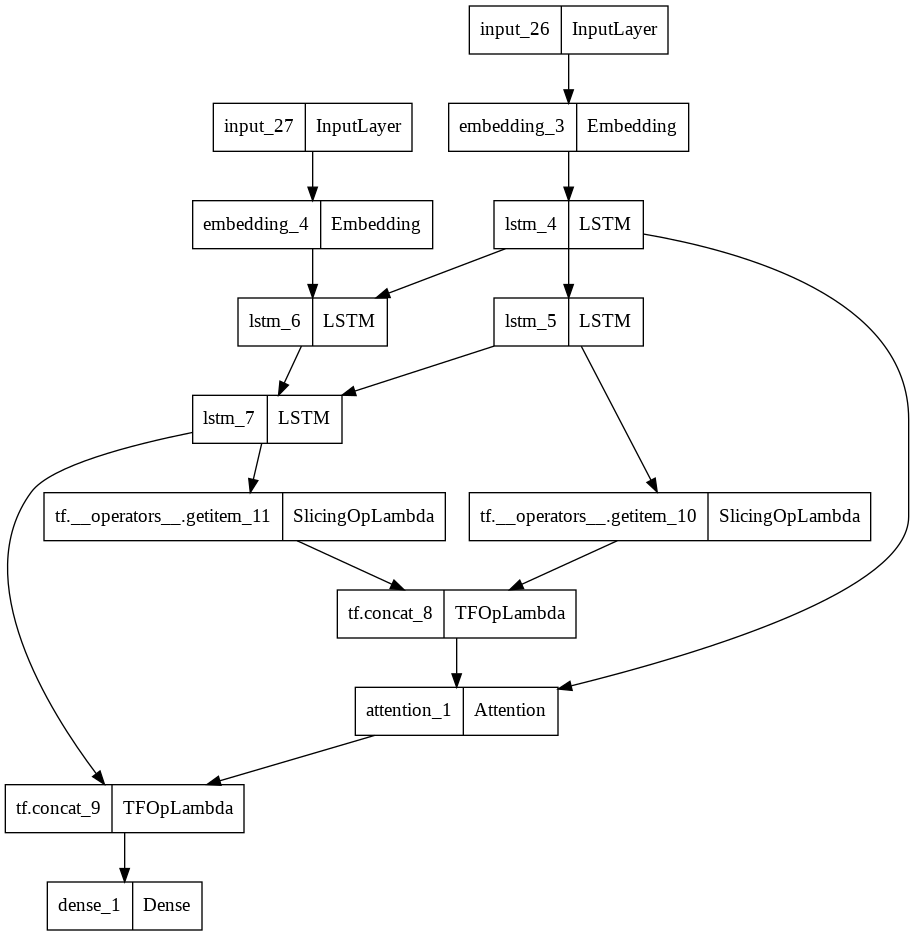

In [151]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [152]:
from tensorflow.keras.callbacks import ModelCheckpoint
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint(
    'attention2.h5', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False)
]
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, epochs=3, callbacks=[callback])

RuntimeError: ignored

In [73]:
#최종번역기
from tensorflow.keras.models import Model

# 인코더 - 훈련과 동일

encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states,encoder_states2, encoder_states3, encoder_states4])

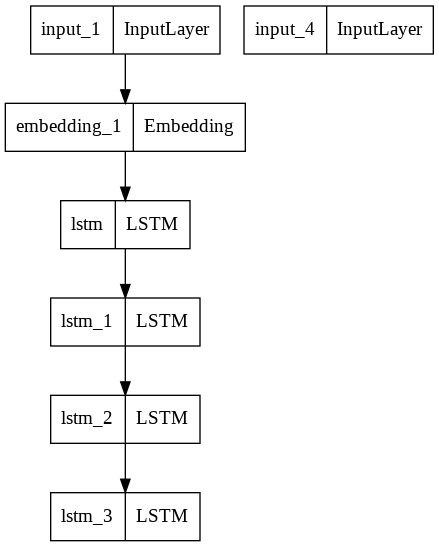

In [74]:
tf.keras.utils.plot_model(encoder_model, to_file='model.png', )

In [75]:
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     13196032    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, None, 256),  328704      ['embedding_1[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [76]:
# 디코더 
query_vec = Input(shape=(hidden_units,))
encoder_outputs = Input(shape =(None, hidden_units,))

# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_state_input_h2 = Input(shape=(hidden_units,))
decoder_state_input_c2 = Input(shape=(hidden_units,))
decoder_states_inputs2 = [decoder_state_input_h2, decoder_state_input_c2]

decoder_state_input_h3 = Input(shape=(hidden_units,))
decoder_state_input_c3 = Input(shape=(hidden_units,))
decoder_states_inputs3 = [decoder_state_input_h3, decoder_state_input_c3]

decoder_state_input_h4 = Input(shape=(hidden_units,))
decoder_state_input_c4 = Input(shape=(hidden_units,))
decoder_states_inputs4 = [decoder_state_input_h4, decoder_state_input_c4]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs2, state_h2, state_c2 = decoder_lstm2(decoder_outputs, initial_state=decoder_states_inputs2)
decoder_states2 = [state_h2, state_c2]

decoder_outputs3, state_h3, state_c3 = decoder_lstm3(decoder_outputs2, initial_state=decoder_states_inputs3)
decoder_states3 = [state_h3, state_c3]

decoder_outputs4, state_h4, state_c4 = decoder_lstm4(decoder_outputs3, initial_state=decoder_states_inputs4)
decoder_states4 = [state_h4, state_c4]

# Attention
S_ = tf.concat([query_vec[:, tf.newaxis, :], decoder_outputs4[:, :-1, :]], axis=1) # query 

context_vector, att_score = attention([S_, encoder_outputs], return_attention_scores = True)
decoder_concat = tf.concat([decoder_outputs4, context_vector], axis=-1)

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_concat)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs, query_vec, encoder_outputs] + [decoder_states_inputs,decoder_states_inputs2,decoder_states_inputs3,decoder_states_inputs4],
    [decoder_outputs2, att_score] + [decoder_states, decoder_states2, decoder_states3, decoder_states4])

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 256)    16310784    ['input_2[0][0]']                
                                                                                                  
 input_15 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 256)]        0           []                               
                                                                                            

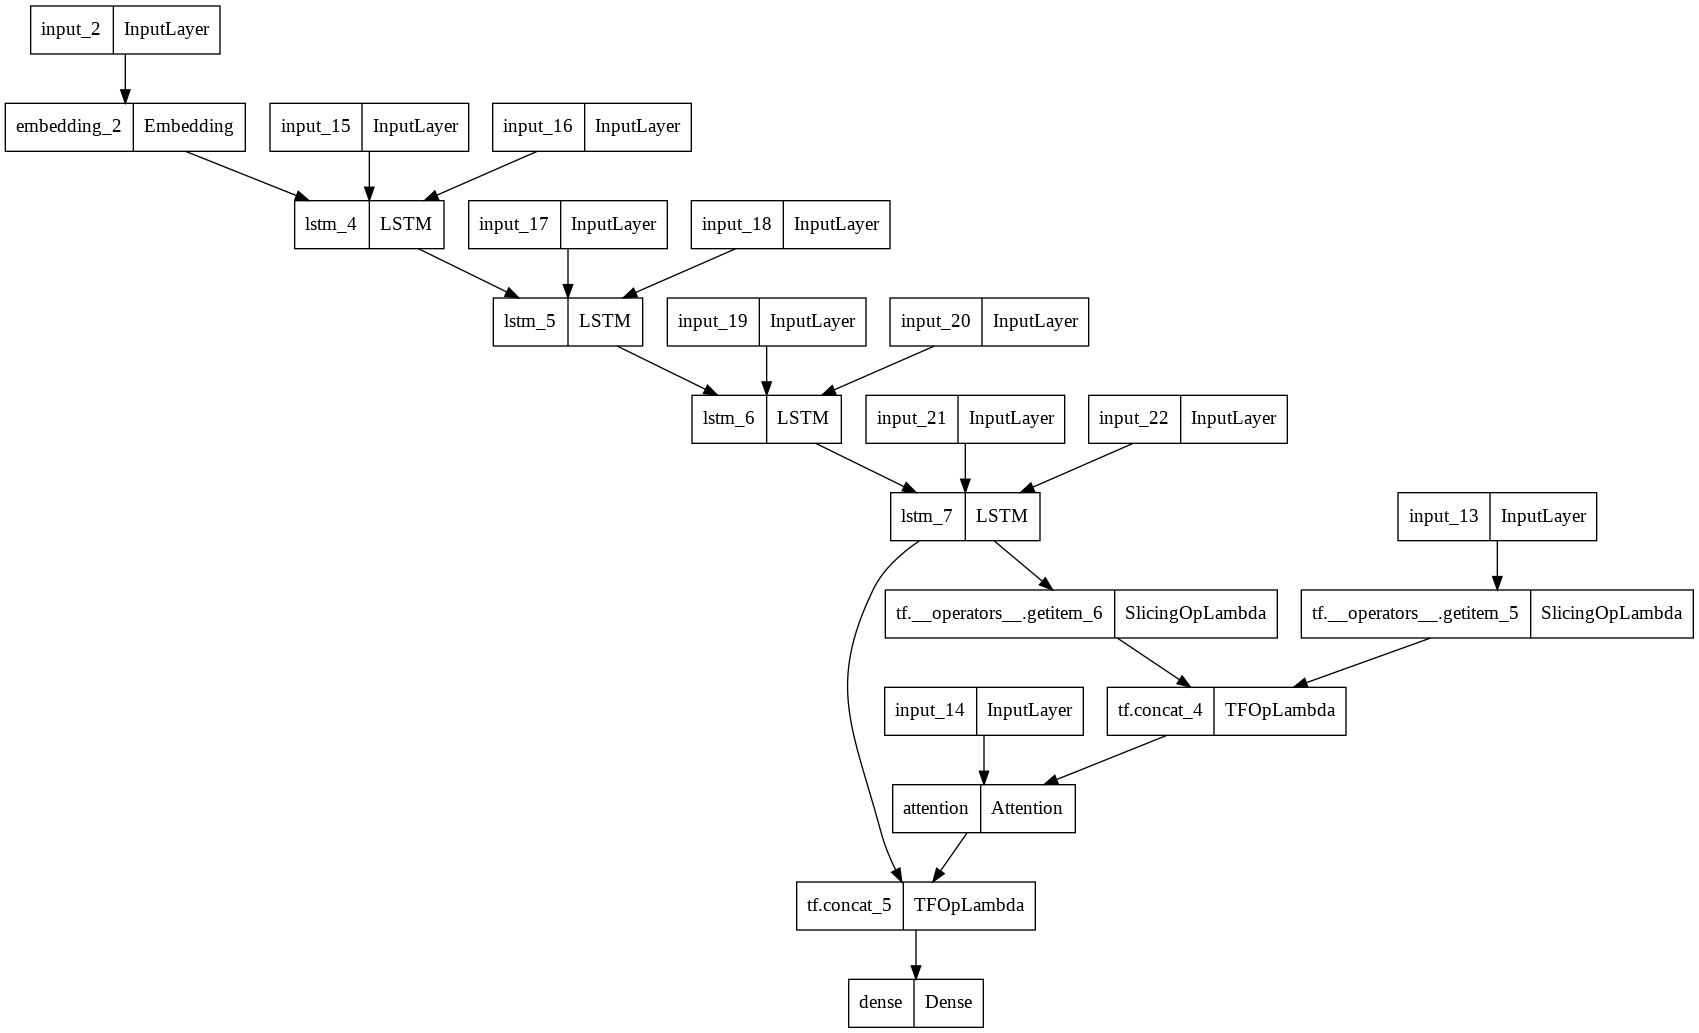

In [77]:
decoder_model.summary()
tf.keras.utils.plot_model(decoder_model, to_file='model.png', )

In [78]:
def decode_sequence(sentence):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    max_src_len, max_tar_len  = 30, 60

    attention_plot = np.zeros((max_tar_len, max_src_len))

    sentence = preprocessing(sentence)
    tokens = sentence.split(" ")

    inputs = tokenizer_kor.texts_to_sequences([tokens])

    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_src_len,padding='post')

    encoder_test, states_value, states_value2, states_value3, states_value4 = encoder_model.predict(inputs)

    states_value = [states_value, states_value2, states_value3, states_value4]
    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    for t in range(max_tar_len):
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, att_score, hc, hc2, hc3, hc4= decoder_model.predict([target_seq, states_value[3][0], encoder_test] + states_value)

        # 어텐션 가중치 시각화를 위해 저장 
        att_score = tf.reshape(att_score, (-1, ))
        attention_plot[t] = att_score.numpy() 

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          sampled_char = ' '
        else:
          sampled_char = index_to_tar[sampled_token_index]
        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char


        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [hc, hc2, hc3, hc4]

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if sampled_char == '<eos>':
            break 

    return sentence, decoded_sentence, attention_plot

In [79]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<eos>']):
    # if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [80]:
def translate_train(seq_index):
  input_seq = encoder_input_train[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_train[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

#   attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
#   plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [81]:
indices = np.random.randint(10000, size = (5,))
print(indices)
for seq_index in indices:
    translate_train(seq_index)
    print("-"*50)

[5483 4276 3994  285 2361]


RuntimeError: ignored

In [71]:
import csv
from tqdm import tqdm
import pandas as pd
def translate(sentence):
  sentence, result, attention_plot = decode_sequence(sentence)
  return result
df_csv = pd.read_csv('/content/한영번역_타켓문장.csv')
f = open('한영번역_타겟문장_kjhcsv2','w', newline='')
wr = csv.writer(f)
wr.writerow(['','한글', '영어'])
for i, sentence in tqdm(enumerate(df_csv['한글'])):
    wr.writerow([str(i), sentence, decode_sequence(sentence)[1].replace('<eos>', '')])
print('end!')

0it [00:00, ?it/s]


RuntimeError: ignored